In [35]:
# Helper packages
import numpy as np
import pandas as pd
from plotnine import *

# Modeling pre-processing with scikit-learn functionality
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from feature_engine.encoding import RareLabelEncoder  # this might need to be installed use this comand: ! pip install -U feature_engine
from sklearn.feature_selection import VarianceThreshold
from pyearth import Earth

# Pickling packages
import pickle

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn import compose

from sklearn.metrics import *


In [3]:
# reading the data, the train set and the test set.
cars = pd.read_csv("../EDA/cleaned_data.csv")
cars_Train =  pd.read_csv("../EDA/train.csv")
cars_Test =  pd.read_csv("../EDA/test.csv")

In [4]:
# separate features from labels and only use numeric features
X_train = cars_Train.drop("Price", axis=1)
y_train = cars_Train[["Price"]]

## Target engineering

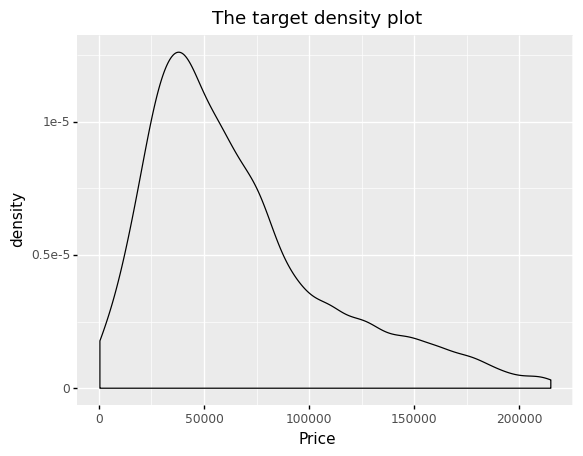

<ggplot: (8774260319853)>

In [5]:
# investigating the normality of the target.
(ggplot(cars_Train, aes('Price'))
 + geom_density()
 + ggtitle("The target density plot"))

The target is positively skewed, so it need to be transfirmed.

In [30]:
# creating transformer object
targetTrans = TransformedTargetRegressor(transformer=PowerTransformer(method='box-cox'))


## Dealing With Missing Values

In [7]:
# We already delt wit this issue.
cars.isnull().sum()

Make            0
Type            0
Year            0
Origin          0
Color           0
Options         0
Engine_Size     0
Fuel_Type       0
Gear_Type       0
Mileage         0
Region          0
Price           0
Negotiable      0
Manu_Country    0
dtype: int64

## Features Engineering

In [8]:
# check that numerical features' variance is greater than 1
X_train.describe().T["std"] 

Year                4.999629
Engine_Size         1.448652
Mileage        102270.093466
Name: std, dtype: float64

In [9]:
# Normalizing the nimerical features (to deal with skewed distribution)
# Normalizing approach
yj = PowerTransformer(method="yeo-johnson")

# standerizing the nimerical features (to deal with wide range features)
# standerizing approach
scaler = StandardScaler()


### Categorical Features Engineering

In [10]:
# encoding the categoricale features.

# one-hot encoder
encoder = OneHotEncoder()

hot = ColumnTransformer([("one-hot", encoder, selector(dtype_include="object"))])

#### Lumping the rare levels together as "Other",
which is useful since we have features with rare levels such as Make and Type.

In [11]:
# Lumping the year feature

# the propution of each level
year_freq = X_train.Year.value_counts().mul(1/(X_train.shape[0]))

# replace the small levels by "other"
year_updated = X_train.Year.replace(year_freq[year_freq<0.01].index , "other")

X_train["Year"] = year_updated.astype(str)

In [12]:
# Lumping the make feature

# the propution of each level
make_freq = X_train.Make.value_counts().mul(1/(X_train.shape[0]))

# replace the small levels by "other"
make_updated = X_train.Make.replace(make_freq[make_freq<0.01].index , "other")

X_train["Make"] = make_updated

In [13]:
# Lumping the year feature

# the propution of each level
type_freq = X_train.Type.value_counts().mul(1/(X_train.shape[0]))

# replace the small clevels by "other"
type_updated = X_train.Type.replace(type_freq[type_freq<0.01].index , "other")

X_train["Type"] = type_updated

In [14]:
# Lumping the year feature

# the propution of each level
Manu_Country_freq = X_train.Manu_Country.value_counts().mul(1/(X_train.shape[0]))

# replace the small levels by "other"
Manu_Country_updated = X_train.Manu_Country.replace(Manu_Country_freq[Manu_Country_freq<0.01].index , "other")

X_train["Manu_Country"] = Manu_Country_updated

we are not going to use principal components analysis because We do not have many numerical features.

## Putting everything togather.

In [15]:
# Creating a preprocessor to use in model_pipline

preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("norm", yj, selector(dtype_include="number")),  # normalyze
  ("std", scaler, selector(dtype_include="number")),  # standerize
  ("one-hot", encoder, selector(dtype_include="object")) # encode categorical features
  ])

In [16]:
X_train.Year.astype(str)

0        2020
1        2009
2        2018
3       other
4        2016
        ...  
3292     2010
3293     2019
3294     2014
3295     2014
3296     2018
Name: Year, Length: 3297, dtype: object

##  k-nearest neighbor model

In [36]:
knn = KNeighborsRegressor()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
kfold = KFold(n_splits=10, random_state=123, shuffle=True)

# Create grid of hyperparameter values
hyper_grid = {'knn__n_neighbors': range(2, 26)}

model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("knn", knn),
])


# Tune a knn model using grid search
grid_search = GridSearchCV(model_pipeline, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train, y_train)



In [18]:
# Best model's cross validated RMSE
abs(results.best_score_)


26773.339933347735

In [19]:
# Best model's k value
results.best_estimator_.get_params().get('knn__n_neighbors')

8

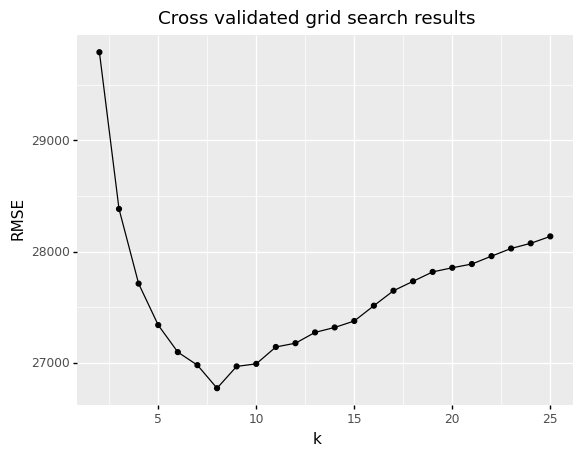

<ggplot: (8774260944282)>

In [20]:
# Plot all RMSE results
all_rmse = pd.DataFrame({'k': range(2, 26), 
                         'RMSE': np.abs(results.cv_results_['mean_test_score'])})

(ggplot(all_rmse, aes(x='k', y='RMSE'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))

### Testing our model

In [21]:
preprocessor1 = compose.ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("norm", yj, selector(dtype_include="number")),  # normalyze
  ("std", scaler, selector(dtype_include="number")),  # standerize
  ("one-hot", encoder, selector(dtype_include="object")) # encode categorical features
  ])

KNN = KNeighborsRegressor(n_neighbors=8)

X_train_trans = preprocessor1.fit_transform(X_train)

final_Knn = KNN.fit(X_train_trans, y_train)



In [34]:
X_test = cars_Train.drop("Price", axis=1)
y_test = cars_Train[["Price"]]

X_test_encoded = preprocessor1.fit_transform(X_train)

final_knn_prediction = final_Knn.predict(X_test_encoded)

mean_squared_error(y_test, final_knn_prediction)**(1/2)

23394.05922576326

## MARS

In [45]:
# creat a MARS model
earth_mod = Earth()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
kfold = KFold(n_splits=10, random_state=123, shuffle=True)

# Create grid of hyperparameter values
hyper_grid = {'max_degree': range(1, 3),
            'max_terms': range(1, 30, 3)
              }

X_train_encoded = pd.get_dummies(X_train)

# Tune an earth model using grid search
grid_search = GridSearchCV(model_pipeline, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train_encoded, y_train)

ValueError: Invalid parameter max_degree for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('norm', PowerTransformer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faeab0e7280>),
                                                 ('std', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faeab0e71f0>),
                                                 ('one-hot', OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faeab0e7520>)])),
                ('earth', Earth())]). Check the list of available parameters with `estimator.get_params().keys()`.

### Pickling the final model

In [31]:

outfile = open("../pickles/KNN_model.pkl", "wb")
pickle.dump(final_Knn, outfile)
outfile.close()
